# Imports

In [1]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud
from PIL import Image
from bs4 import BeautifulSoup
import numpy as np

from sklearn.model_selection import train_test_split


%matplotlib inline

# Constants

In [98]:
PATH = r'SpamData\01_Processing\spam_assassin_corpus'
SPAM_1=r'\spam_1'
SPAM_2=r'\spam_2'
EASY_HAM_1=r'\easy_ham_1'
EASY_HAM_2=r'\easy_ham_2'
SKULL = r'SpamData\01_Processing\wordcloud_resources\skull-icon.png'
WORD_LIST_FILE = 'SpamData/01_Processing/word-by-id.csv'
TRAINING_DATA = r'SpamData\02_Training\train-data.txt'
TEST_DATA = r'SpamData\02_Training\test-data.txt'

# Preparing Data

In [3]:
def get_email_body(DIR):
    for root,dirs,filename in walk(PATH+DIR):
        for filenames in filename:
            filepath=join(PATH+DIR,filenames)
            stream = open(filepath,encoding='latin-1')
            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()
            email_body = '\n'.join(lines)
            yield filenames,email_body
    

In [4]:
def create_dataframe(DIR,classification):
    emails=[]
    idx=[]
    for filenames,email_body in get_email_body(DIR):
        emails.append({'MESSAGE':email_body,'CLASS':classification})
        idx.append(filenames)
    return pd.DataFrame(emails,index=idx)



In [5]:
%%time
data=create_dataframe(SPAM_1,1)
data=data.append(create_dataframe(SPAM_2,1))
data=data.append(create_dataframe(EASY_HAM_1,0))
data=data.append(create_dataframe(EASY_HAM_2,0))
data.shape

Wall time: 42.4 s


(5799, 2)

In [6]:
(data['MESSAGE'].str.len()==0).any()

True

In [7]:
data[data.MESSAGE.str.len()==0]

,MESSAGE,CLASS
cmds,,1
cmds,,1
cmds,,0


In [8]:
data = data.drop(['cmds'])
(data['MESSAGE'].str.len()==0).any()

False

In [9]:
data.shape

(5796, 2)

In [10]:
data.head()

,MESSAGE,CLASS
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [11]:
data['FILE_NAME']=data.index

In [12]:
data.head()

,MESSAGE,CLASS,FILE_NAME
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
00004.eac8de8d759b7e74154f142194282724,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


In [13]:
data['Doc_Id']=range(0,len(data.index))

In [14]:
data.head()

,MESSAGE,CLASS,FILE_NAME,Doc_Id
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0,0
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c,2
00004.eac8de8d759b7e74154f142194282724,##############################################...,1,00004.eac8de8d759b7e74154f142194282724,3
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d,4


In [15]:
data.set_index('Doc_Id',inplace=True)

In [16]:
data.head()

,MESSAGE,CLASS,FILE_NAME
Doc_Id,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


In [17]:
#data.to_json( r'D:\0MY FILES\DEEP@K\CS Project\PYTHON\ML and Data Science\0Projects\Spam_mail_Classifier\SpamData\email_data.json')

# Data Visualisation

In [18]:
SPAM=data.CLASS.value_counts()[1]
HAM=data.CLASS.value_counts()[0]

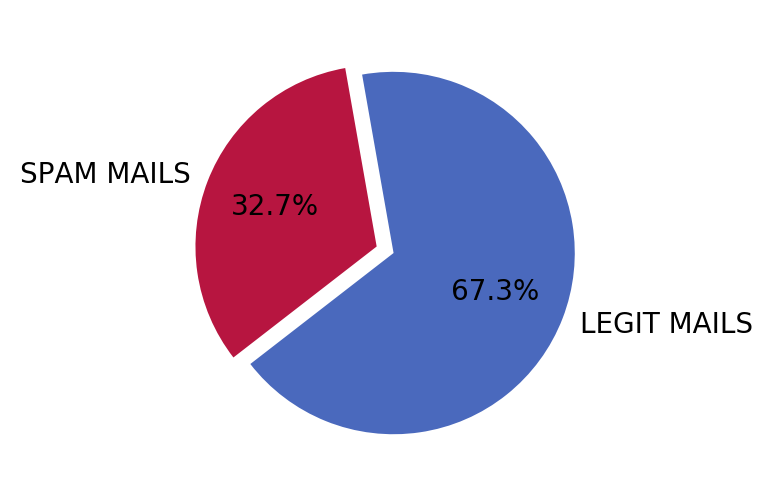

In [19]:
size=[SPAM,HAM]
names=['SPAM MAILS','LEGIT MAILS']
plt.figure(figsize=(3,3),dpi=200)
plt.pie(size,labels=names,autopct='%1.1f%%',explode=[0,0.1],startangle=100,colors=['#b71540','#4a69bd'])
plt.show()

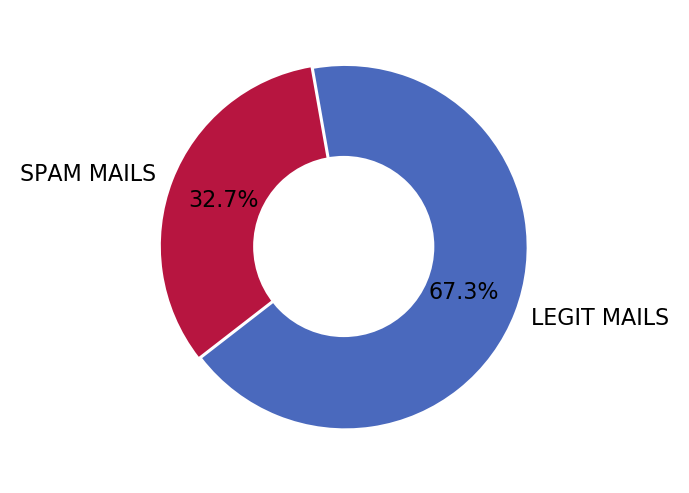

In [20]:
#Donut Chart

size=[SPAM,HAM]
names=['SPAM MAILS','LEGIT MAILS']
plt.figure(figsize=(3,3),dpi=200)
plt.pie(size,labels=names,autopct='%1.1f%%',startangle=100,colors=['#b71540','#4a69bd'],
        pctdistance=0.7,textprops={'fontsize':8},explode=[0.01,0.01])
circle=plt.Circle((0,0),radius=0.5,fc='white')
plt.gca().add_artist(circle)
plt.show()

# Natural Language Processing

In [21]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\DEVIL
[nltk_data]     LORD\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [22]:
stop_words=stopwords.words('english')

In [23]:
msg='i am trying to become a Data Scientist and to be or not to be'

In [24]:
words=[]
for word in word_tokenize(msg.lower()):
    if word not in stop_words:
        #Stemming the word
        stemmer = PorterStemmer()
        stemmed_word = stemmer.stem(word)
        words.append(stemmed_word)
        
print(words)
    

['tri', 'becom', 'data', 'scientist']


# Cleaning HTML Tags

In [25]:
def clean_email_body(message,stop_words=stopwords.words('english')):
    soup = BeautifulSoup(message,'html.parser')
    clean_msg = soup.get_text()
    words=[]
#     stemmer = PorterStemmer()
    stemmer = SnowballStemmer('english')
    for word in word_tokenize(clean_msg.lower()):
        if word not in stop_words and word.isalpha():
            words.append(stemmer.stem(word))
    return words

In [26]:
clean_email_body(data.at[2,'MESSAGE'])

['fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guarante',
 'lose',
 'lbs',
 'day',
 'http',
 'get',
 'child',
 'support',
 'deserv',
 'free',
 'legal',
 'advic',
 'http',
 'join',
 'web',
 'fastest',
 'grow',
 'singl',
 'communiti',
 'http',
 'start',
 'privat',
 'photo',
 'album',
 'onlin',
 'http',
 'wonder',
 'day',
 'offer',
 'manag',
 'prizemama',
 'wish',
 'leav',
 'list',
 'pleas',
 'use',
 'link',
 'http',
 'zzzz']

In [27]:
%%time
# cleaned_mails=[]
# for i in range(0,len(data.index)):
#     cleaned_mails.append(clean_email_body(data.at[i,'MESSAGE']))
cleaned_mails = data.MESSAGE.apply(clean_email_body)

c:\users\devil lord\appdata\local\programs\python\python37-32\lib\site-packages\bs4\__init__.py:357: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Wall time: 37.5 s


In [28]:
spam_index = []
for i in range(len(data.index)):
    if data.at[i,'CLASS']==1:
        spam_index.append(i)
spam_mails_cleaned = cleaned_mails.loc[spam_index]

In [29]:
spam_mails_cleaned

Doc_Id
0       [save, life, insur, spend, life, quot, save, g...
1       [fight, risk, cancer, http, slim, guarante, lo...
2       [fight, risk, cancer, http, slim, guarante, lo...
3       [adult, club, offer, free, membership, instant...
4       [thought, might, like, slim, guarante, lose, l...
                              ...                        
1891    [want, boss, train, home, studi, thousand, peo...
1892    [messag, mime, format, prefer, doctor, order, ...
1893    [dear, subscrib, could, show, way, get, visito...
1894    [custom, appreci, sale, express, appreci, loya...
1895    [attn, strict, confidenti, pleas, introduc, na...
Name: MESSAGE, Length: 1896, dtype: object

# Generating WordClouds

In [30]:
spam_words = [word for sublist in spam_mails_cleaned for word in sublist]

In [31]:
spam_words = ' '.join(spam_words) 
spam_words

'save life insur spend life quot save g famili financi secur import life quot save kes buy life insur simpl afford provid free access best compani lowest rate life quot save fast save money let us help get start best ue countri new coverag save hundr even usand dollar request free quot lifequot save servic take less minut complet shop compar save type life insur click free quot protect famili best invest r make receipt email error wish remov list pleas click type remov resid state prohibit solicit ce pleas disregard email fight risk cancer http slim guarante lose lbs day http get child support deserv free legal advic http join web fastest grow singl communiti http start privat photo album onlin http wonder day offer manag prizemama wish leav list pleas use link http ilug irish linux user group ilug http un subscript inform list maintain listmast fight risk cancer http slim guarante lose lbs day http get child support deserv free legal advic http join web fastest grow singl communiti ht

(-0.5, 399.5, 199.5, -0.5)

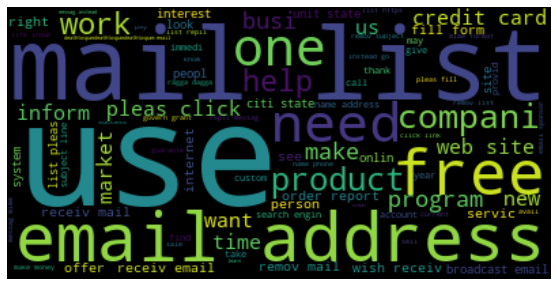

In [32]:
word_cloud = WordCloud().generate(spam_words)
plt.figure(figsize=(10,5))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')

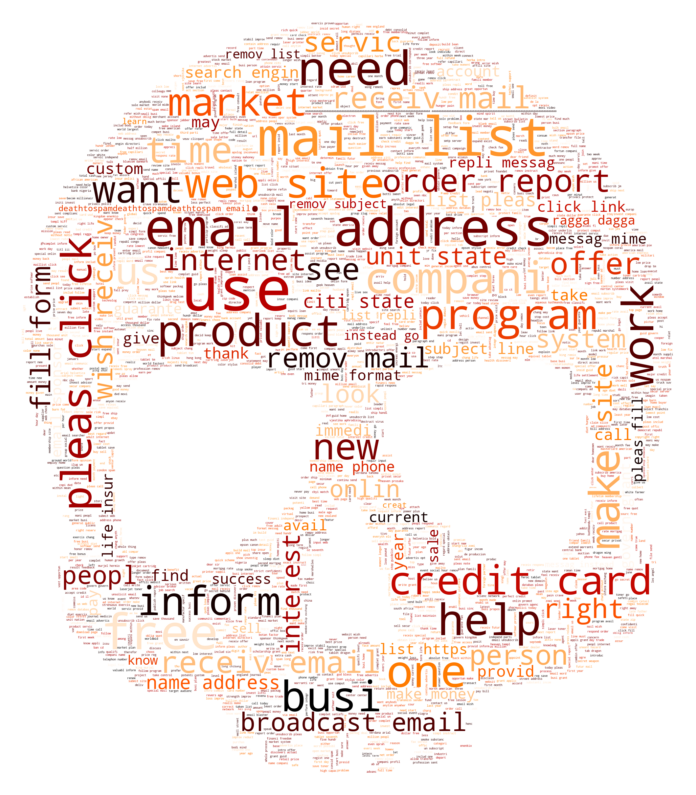

Wall time: 1min 20s


In [33]:
%%time
skull = Image.open(SKULL)
skull_mask = Image.new(mode='RGB',size=skull.size,color=(255,255,255))
skull_mask.paste(skull,box=skull)

img_array = np.array(skull_mask)
word_cloud = WordCloud(mask=img_array,background_color='white',max_words=2000,colormap='gist_heat')

word_cloud.generate(spam_words)

plt.figure(figsize=(5,5),dpi=200)
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

# Creating Vocabulary for the Bayes Classifier

In [34]:
word_list = [word for sublist in cleaned_mails for word in sublist]

In [35]:
frequent_words = pd.Series(word_list).value_counts()

In [36]:
word_dataframe = pd.DataFrame(frequent_words[0:2500].index.values,columns=['VOCAB_WORDS'],index=range(0,2500))

In [37]:
word_dataframe.index.name = 'WORD_ID'
# word_dataframe['FREQUENCY'] = frequent_words[0:2500].values

In [38]:
word_dataframe.head()

,VOCAB_WORDS
WORD_ID,
0,http
1,use
2,list
3,email
4,get


# Saving Word-List to csv

In [39]:
word_dataframe.to_csv(WORD_LIST_FILE)

In [40]:
stemmer = PorterStemmer()
stemmer.stem('machine') in set(word_dataframe.VOCAB_WORDS)

True

In [41]:
#email with the most number of words
i=0
for sublist in cleaned_mails:
    if sublist == cleaned_mails.max():
        print(i)
    i+=1

1284


In [42]:
clean_email_lengths = []
for sublist in cleaned_mails:
    clean_email_lengths.append(len(sublist))

In [43]:
max(clean_email_lengths)

7671

In [44]:
cleaned_mails

Doc_Id
0       [save, life, insur, spend, life, quot, save, g...
1       [fight, risk, cancer, http, slim, guarante, lo...
2       [fight, risk, cancer, http, slim, guarante, lo...
3       [adult, club, offer, free, membership, instant...
4       [thought, might, like, slim, guarante, lose, l...
                              ...                        
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, Length: 5796, dtype: object

# Generating Feature and Sparse Matrix

In [45]:
word_df = pd.DataFrame.from_records(cleaned_mails.tolist())
word_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lbs,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lbs,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lbs,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


## Splitting the Data

In [46]:
x_train,x_test,y_train,y_test = train_test_split(word_df,data.CLASS,test_size=0.3,random_state=42)

In [47]:
x_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
4844,yes,inde,agent,directori,verita,cd,unix,subdirectori,file,call,...,None,None,None,None,None,None,None,None,None,None
4727,problem,come,tri,instal,harddissssk,like,alreadi,mount,http,yahoo,...,None,None,None,None,None,None,None,None,None,None
5022,origin,messag,date,mon,aug,chad,norwood,sven,cc,subject,...,None,None,None,None,None,None,None,None,None,None
3504,inlin,folk,sever,major,internet,outag,morn,across,major,provid,...,None,None,None,None,None,None,None,None,None,None
3921,url,http,date,bath,chronicl,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [48]:
y_train.head()

Doc_Id
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CLASS, dtype: int64

In [51]:
x_train.index.name = y_train.index.name = 'DOC_ID'

## Creating Sparse matrix

In [49]:
cleaned_mails

Doc_Id
0       [save, life, insur, spend, life, quot, save, g...
1       [fight, risk, cancer, http, slim, guarante, lo...
2       [fight, risk, cancer, http, slim, guarante, lo...
3       [adult, club, offer, free, membership, instant...
4       [thought, might, like, slim, guarante, lose, l...
                              ...                        
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, Length: 5796, dtype: object

In [50]:
word_dataframe

,VOCAB_WORDS
WORD_ID,
0,http
1,use
2,list
3,email
4,get
5,mail
6,one
7,free
8,time


In [52]:
word_index = pd.Index(word_dataframe.VOCAB_WORDS)

In [78]:
'http' in word_index

True

In [85]:
def create_sparse_matrix(dataframe,index,labels):
    sparse_matrix=[]
    
    for i in range(dataframe.shape[0]):
        doc_id = dataframe.index[i]
        for j in range(dataframe.shape[1]):
            word = dataframe.iat[i,j]
            if word in index:
                word_id = index.get_loc(word)
                label = labels.iat[i]
                sparse_matrix.append({'DOC_ID':doc_id,'WORD_ID':word_id,'LABEL':label,'OCCURENCE':1})
    return pd.DataFrame(sparse_matrix)

In [87]:
%%time
test_sparse=create_sparse_matrix(x_test,word_index,y_test)

Wall time: 1min 26s


In [105]:
test_sparse=test_sparse.groupby(['DOC_ID','WORD_ID','LABEL']).sum().reset_index()

In [92]:
%%time
train_sparse=create_sparse_matrix(x_train,word_index,y_train)

Wall time: 3min 33s


In [102]:
train_sparse=train_sparse.groupby(['DOC_ID','WORD_ID','LABEL']).sum().reset_index()

## Saving all the data

In [103]:
np.savetxt(TRAINING_DATA,train_sparse,fmt='%d')

In [106]:
np.savetxt(TEST_DATA,test_sparse,fmt='%d')